In [1]:
%reset -f
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow.keras
import pickle, sys, warnings, os, time, random
import matplotlib.pyplot as plt

sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import to_categorical


2022-10-15 18:46:42.953390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-10-15 18:46:42.953419: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
##############################################################################
# IMPORT DEEP LEARNING PACKAGES
##############################################################################

from sklearn.model_selection import cross_val_score, StratifiedKFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, accuracy_score
LeakyReLU = LeakyReLU(alpha=0.1)

from bayes_opt import BayesianOptimization


pd.set_option("display.max_columns", None)


# ENCODING FUNCTIONS
##############################################################################

# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
##############################################################################
# PLOTTING FUNCTIONS 
##############################################################################
def history_plots_(history, SAVE = 0, name = ''):
    auc_keys = [x for x in history.history.keys() if 'auc' in x]
    loss = history.history["loss"];     val_loss = history.history["val_loss"]
    acc  = history.history["accuracy"]; val_acc  = history.history["val_accuracy"]
    auc  = history.history[auc_keys[0]];      val_auc = history.history[auc_keys[1]]
    epochs  = range(1, len(acc) + 1)
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (8,4))
    ax0.plot(epochs, loss, "bo", label="Training Loss")
    ax0.plot(epochs, val_loss, "b", label="Validation Loss")
    ax0.set_title("Train-val Loss")
    ax1.plot(epochs, acc, "bo", label="Training Accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation Accuracy")
    ax1.set_title("Train-val Accuracy")
    ax2.plot(epochs, auc, "bo", label="Training AUC")
    ax2.plot(epochs, val_auc, "b", label="Validation AUC")
    ax2.set_title("Train-val AUC")
    plt.legend()
    if SAVE == 1: plt.savefig(name, transparent = True, bbox_inches = "tight")
    plt.show()
# ============================================================================


In [3]:
t_tot = time.time()
# ##############
# 1. LOAD DATA ---------------------------------------------------------------
# ============================================================================
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
#df_patients_16_18, df_admissions_16_18, _ = load_fn.Load_data()
#df_patients_19_20, df_admissions_19_20, _ = load_fn.Load_data('2019_2020')

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18_ews_1d.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20_ews_1d.pickle','rb'))

# List of features ------------------------
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]

# Dictionary of features and types --------
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
data_types = data_types.set_index('Variable').to_dict()['Type']

# Resulst vaiables ------------------------
df_results_train = pd.DataFrame()
df_results_valid = pd.DataFrame()
dict_fpr_tpr = {}

print("Elapsed time loading data:", time.time()-t)
# ============================================================================


# ##############
# 2. PROCESSING DATA ---------------------------------------------------------
# ============================================================================
t = time.time()
### BALANCED DATA ####################################
random.seed(2)
adm_list = X_data_16_18[0]['admission_id'].unique().tolist()
X_0 = X_data_16_18[0][X_data_16_18[0]['Mortality'] == 0]['admission_id'].unique().tolist()
X_1 = X_data_16_18[0][X_data_16_18[0]['Mortality'] == 1]

list_X_0   = random.sample(range(len(X_0)),len(X_1['admission_id'].unique().tolist()))
X_0_2_adms = [X_0[pos] for pos in list_X_0]
X_0_2      = X_data_16_18[0][X_data_16_18[0]['admission_id'].isin(X_0_2_adms)]

idx_final = [idx for idx, adm in enumerate(adm_list) if (adm in X_0_2_adms) or (adm in X_1['admission_id'].unique().tolist())]


X_data_bal = pd.concat([X_1,X_0_2])
y_data_bal = [ews for idx, ews in enumerate(X_data_16_18[1]) if idx in idx_final]

### SPLIT DATA #######################################
train_set = X_data_bal.copy()
#train_set = X_data_16_18[0].copy()
valid_set = X_data_19_20[0].copy()

### ENCODING DATA ####################################
train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)

### SET DATA AS ARRAYs ###############################
num_samp_train = len(train_set['admission_id'].unique().tolist())
num_samp_valid = len(valid_set['admission_id'].unique().tolist())
num_features   = len(train_set_norm.columns.tolist())
num_time_samp  = len(train_set[train_set['admission_id']==train_set['admission_id'].tolist()[0]])
X_train    = np.array(train_set_norm).reshape((num_samp_train, num_time_samp, num_features ))
X_valid    = np.array(valid_set_norm).reshape((num_samp_valid, num_time_samp, num_features ))
X_valid_n  = X_valid[:,0,:] 
df         = train_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))

y_train    = y_data_bal.copy()#np.array(X_data_16_18[1].copy())
EWS_bands = lambda x: 0 if x == 0 else 1 if x == 1 else 2 if x == 2 else 3 if x == 3 else 4
y_train = np.array([EWS_bands(x) for x in y_train])


df         = valid_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()
mort_dict  = dict(zip(df.index.tolist(),df['Mortality']))
y_valid    = np.array(X_data_19_20[1].copy())
y_valid    = np.array([EWS_bands(x) for x in y_valid])

### ONE-HOT ENCODING Y ###############################
#y_list = [idx for x in y_train for idx, i in enumerate(x) if i == 1]
y_train_1 = to_categorical(y_train, num_classes = 5)

#y_list = [idx for x in y_valid for idx, i in enumerate(x) if i == 1]
y_valid_1 = to_categorical(y_valid, num_classes = 5)


print("Elapsed time processing data:", time.time()-t)
# ============================================================================
print("Shape of X_train",X_train.shape)
print("Shape of y_train",y_train_1.shape)

print("Shape of X_valid",X_valid.shape)
print("Shape of X_valid",X_valid_n.shape)
print("Shape of y_valid",y_valid.shape)


Elapsed time loading data: 0.18604302406311035
Elapsed time processing data: 19.702807426452637
Shape of X_train (2914, 48, 32)
Shape of y_train (2914, 5)
Shape of X_valid (6531, 48, 32)
Shape of X_valid (6531, 32)
Shape of y_valid (6531,)


_________________________

_________________________

_________________________

In [4]:
final_df = pd.DataFrame()
lst_fpr_tpr = []

# GRU

In [5]:
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS'

********** Balanced_LSTM_Vect_bal_all **********


2022-10-15 18:47:05.709856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-10-15 18:47:05.712803: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-15 18:47:05.713115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spectre11): /proc/driver/nvidia/version does not exist
2022-10-15 18:47:05.713821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

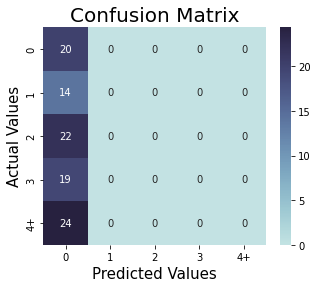

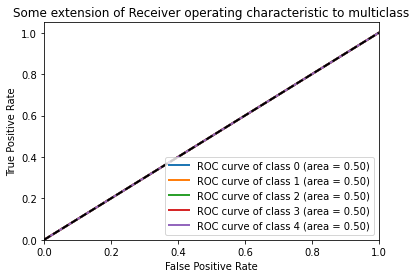

********** Balanced_LSTM_Vect_bal_up65 **********


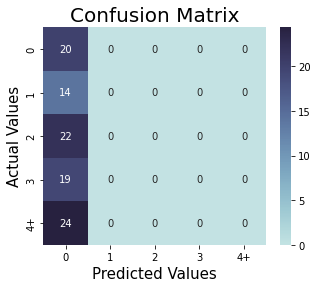

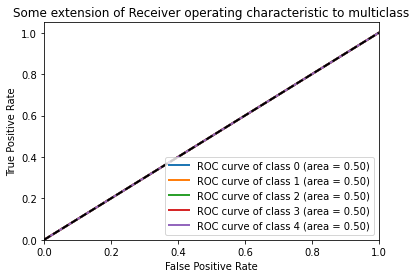

********** Balanced_LSTM_Vect_bal_un65 **********


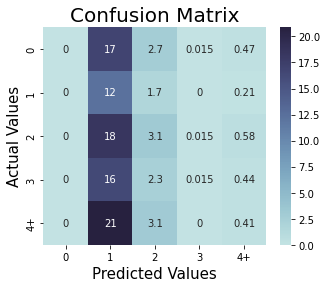

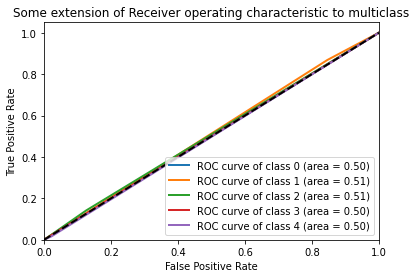

********** Balanced_LSTM_Vect_unbal_all **********


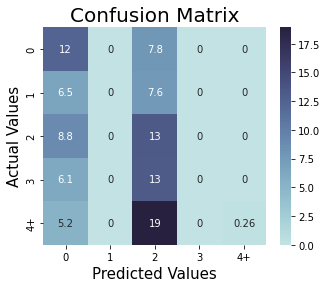

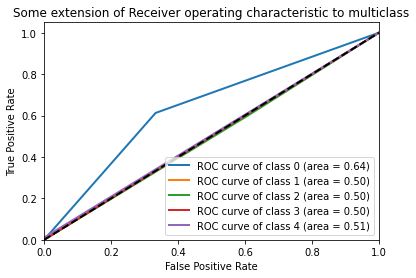

********** Balanced_LSTM_Vect_unbal_un65 **********


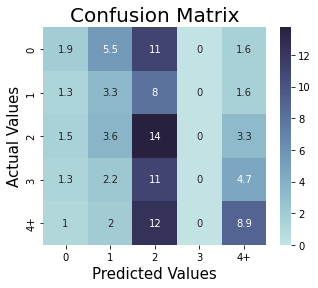

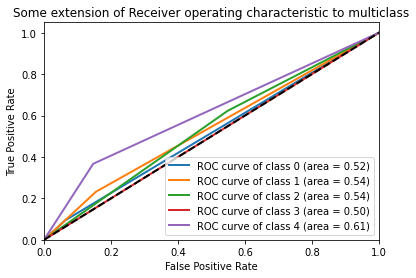

********** Balanced_LSTM_Vect_unbal_up65 **********


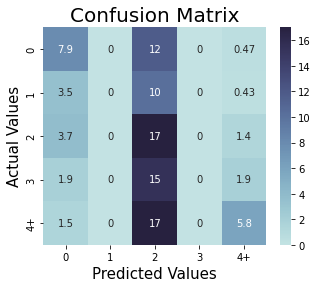

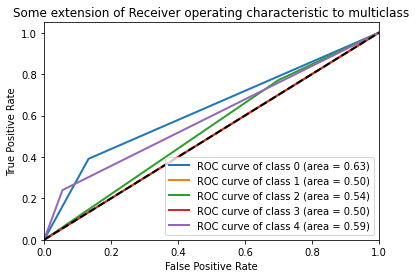

********** Balanced_GRU_Vect_bal_up65 **********


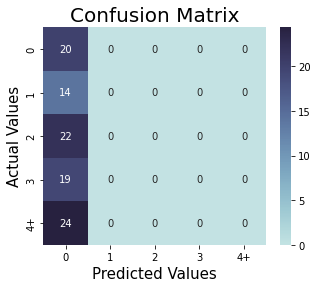

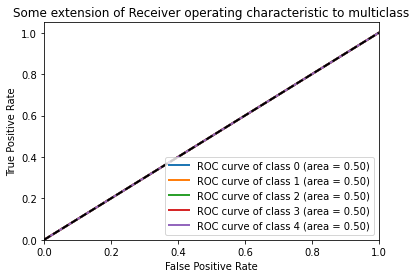

********** Balanced_GRU_Vect_bal_un65 **********


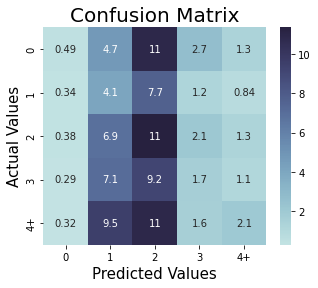

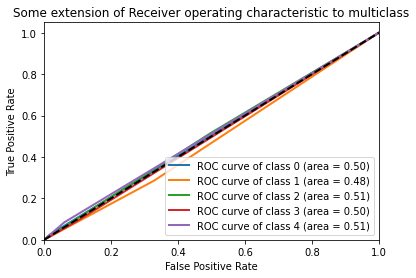

********** Balanced_GRU_Vect_bal_all **********


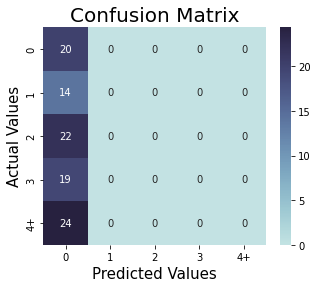

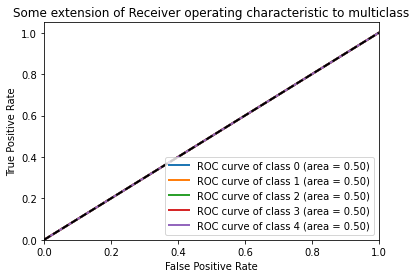

********** Balanced_GRU_Vect_unbal **********


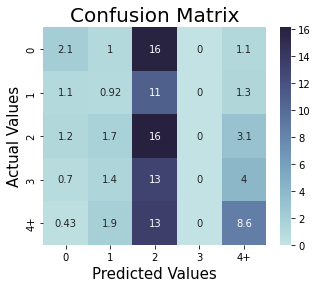

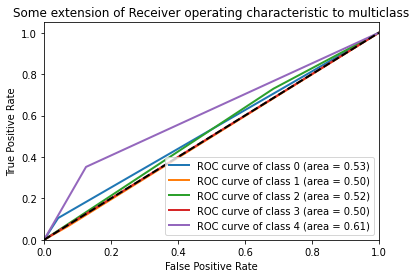

********** Balanced_GRU_Vect_unbal_un65 **********


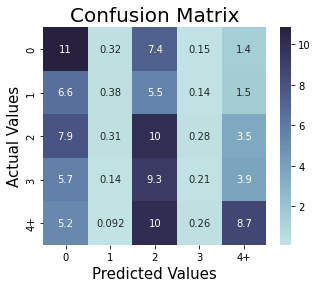

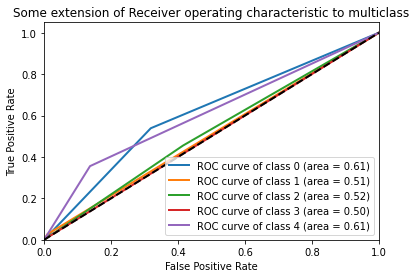

********** Balanced_GRU_Vect_unbal_up65 **********


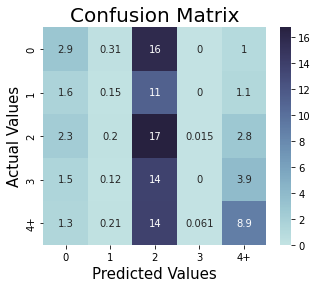

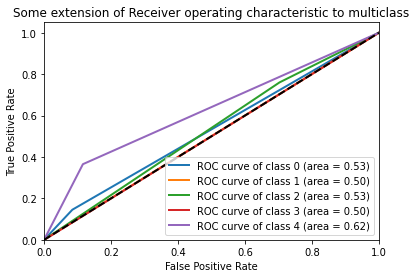

['Balanced_GRU_Vect_unbal',
 'Balanced_GRU_Vect_unbal_un65',
 'Balanced_GRU_Vect_unbal_up65']

In [6]:
cwd = os.getcwd()
ews_folders = [x  for x in os.listdir() if ('EWS' in x) and ('.' not in x) and (('LSTM' in x) or ('GRU' in x))]
label_classes = ['0','1','2','3','4+']
for folder in ews_folders:
    classifier = folder.split('_')[1]
    outcome    = ['scal' if 'scalar' in folder else 'Vect']
    for dt_type in ['Balanced', 'Unbalanced']:
        sub_path = path + r'/' + folder + r'/' + dt_type
        names = [x.replace('_history.pickle','') for x in os.listdir(sub_path) if 'pickle' in x]
        
        for name in names:
            print('*'*10, name, '*'*10)
            pck_fullname = sub_path + r'/' + name + '_history.pickle'
            h5m_fullname = sub_path + r'/' + name + '.h5'
            params_nn_, history= pickle.load(open(pck_fullname,'rb'))
            clf_model = load_model(h5m_fullname)
            
            y_test_proba    = clf_model.predict(X_valid)
            y_test_predict  = np.argmax(y_test_proba, axis=-1)

            LearningCurves.results_precision_recall_cm_multiclass(y_valid, y_test_predict, 
                          y_test_proba,label_classes, fig_size = None, save = True, name = 'EWS_'+name)

display(names)

/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/07_XGB_EWS_scalar/Balanced
['Balanced_XGB_Scal_un65_h5.pickle', 'Balanced_XGB_Scal_up65_h5.pickle', 'Balanced_XGB_Scal_all_h5.pickle']


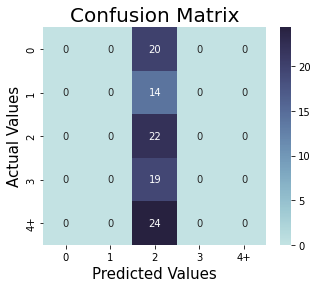

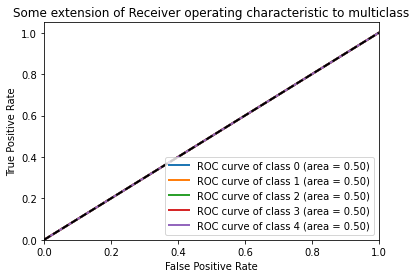

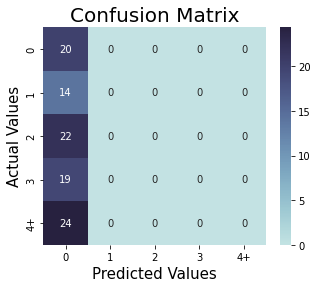

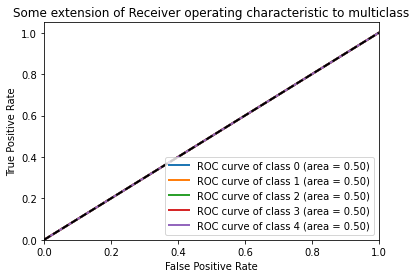

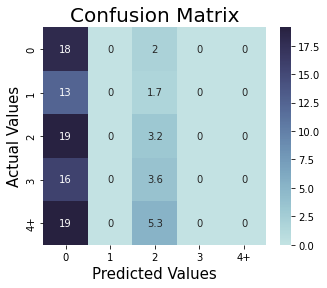

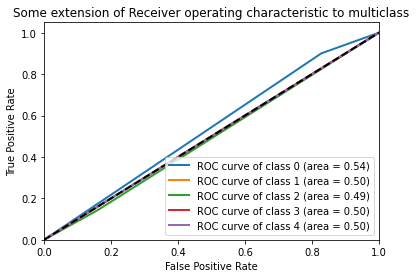

/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/07_XGB_EWS_scalar/Unbalanced
['Unbalanced_XGB_Scal_all_h5.pickle', 'Unbalanced_XGB_Scal_un65_h5.pickle', 'Unbalanced_XGB_Scal_up65_h5.pickle']


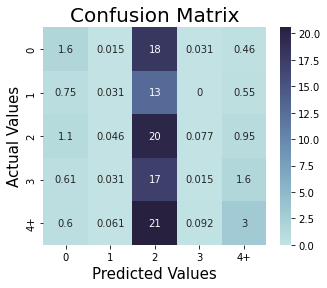

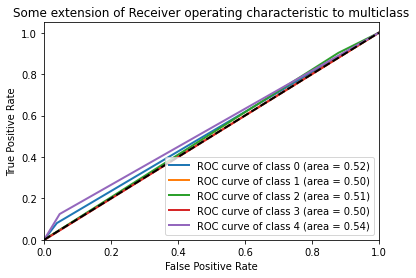

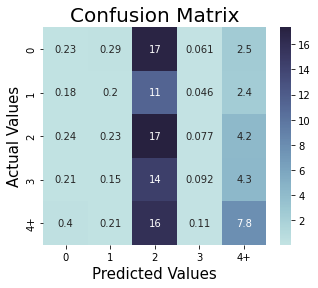

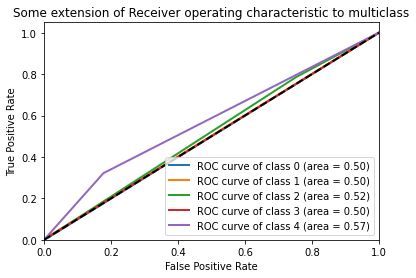

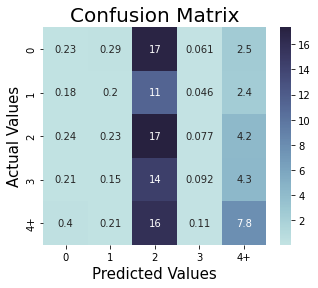

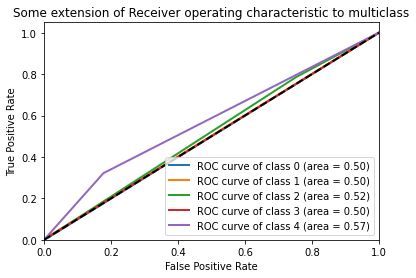

/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/09_SVM_EWS_Scalar/Balanced
['Balanced_SVM_scal_un65_h5.pickle', 'Balanced_SVM_scal_up65_h5.pickle', 'Balanced_SVM_scal_all_h5.pickle']


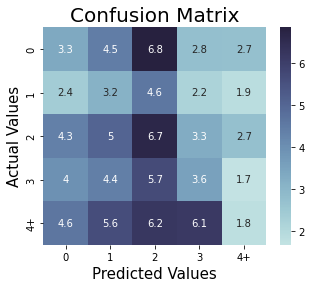

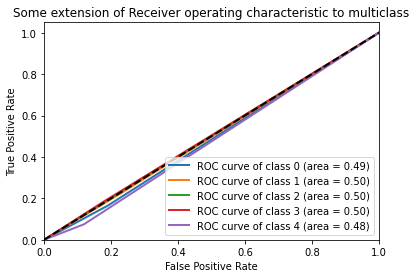

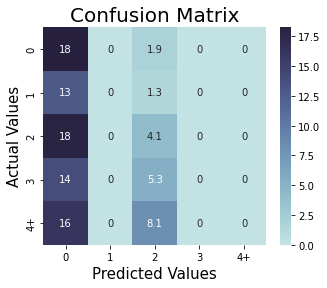

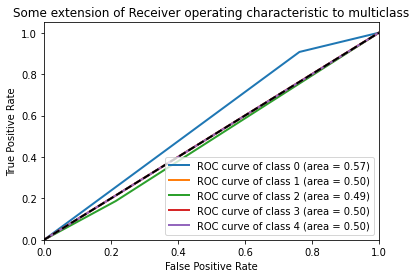

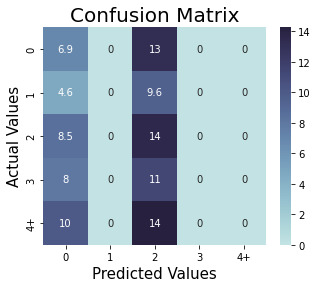

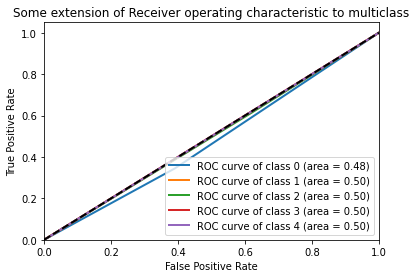

/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS/09_SVM_EWS_Scalar/Unbalanced
['Unbalanced_SVM_scal_up65_h5.pickle', 'Unbalanced_SVM_scal_un65_h5.pickle']


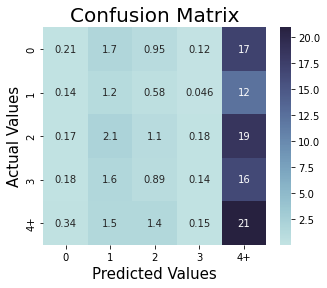

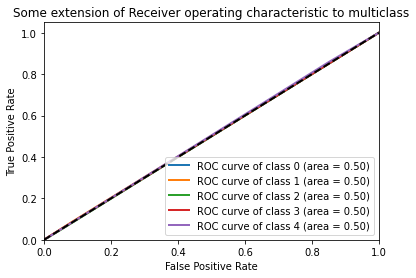

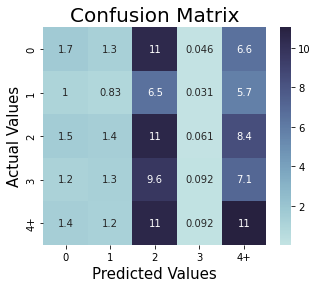

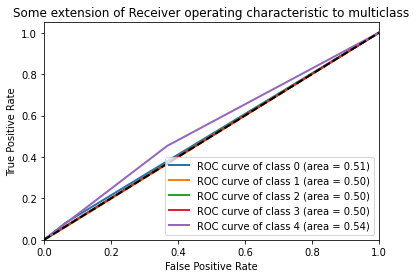

In [7]:
import os, pickle
path     = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS'
folders  = ['07_XGB_EWS_scalar', '09_SVM_EWS_Scalar']
skewness = ['Balanced','Unbalanced']

label_classes = ['0','1','2','3','4+']
for fold in folders:
    for skw in skewness:
        file_path = path + r'/' + fold + r'/' + skw
        pckls = [x  for x in os.listdir(file_path) if ('.pickle' in x)]
        print(file_path)
        print(pckls)
        for pickl in pckls:
            
            param_nn, clf_model = pickle.load(open(file_path + r'/' + pickl,'rb'))
            
            y_test_proba    = clf_model.predict(X_valid_n)
            y_test_predict  = y_test_proba
            name = pickl.replace('_h5.pickle',"")
            LearningCurves.results_precision_recall_cm_multiclass(y_valid, y_test_predict, 
                          y_test_proba,label_classes, fig_size = None, save = True, name = 'EWS_'+name)
            #break
        #break
    #break

In [8]:
name

'Unbalanced_SVM_scal_un65'

In [9]:
y_test_predict.shape

(6531,)

In [10]:
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/5_Modelling_TS_Forecasting/AdmissionSimilarity'

In [11]:
pckl_similarity = pickle.load(open(path + '/Similarity_of_ts.pickle','rb'))

In [12]:
dfs_simil_1, dfs_simil_2, admns_totl = pckl_similarity

In [ ]:
dfs_simil_1[0]

23746739   55485418   62361166   17767888   90687537   73870532  \
23746739          0        NaN        NaN        NaN        NaN        NaN   
55485418  20.684092          0        NaN        NaN        NaN        NaN   
62361166   17.24873  19.894668          0        NaN        NaN        NaN   
17767888  14.835248  11.263849  12.992536          0        NaN        NaN   
90687537  13.472971  30.489519  17.164646  22.167066          0        NaN   
...             ...        ...        ...        ...        ...        ...   
70599885   7.109547   15.58988  12.796592   7.669006   15.29907  35.233375   
25253451  13.268723  15.327321  10.852881   3.964913  18.391917  42.767617   
32108174  54.459443  52.084837  31.134275  44.454348  45.762542  60.057387   
86864065  25.567263  27.994734   7.313557   21.22736   18.21966  34.205729   
70801385  11.506168    7.00766  17.263882   4.868656  22.451091  43.192745   

           9611587    21379572   28583087   49976808   68319139   81253450  \
23746739        NaN        NaN        NaN        NaN        NaN        NaN   
55485418        NaN        NaN        NaN        NaN        NaN        NaN   
62361166        NaN        NaN        NaN        NaN        NaN        NaN   
17767888        NaN        NaN        NaN        NaN        NaN        NaN   
90687537        NaN        NaN        NaN        NaN        NaN        NaN   
...             ...        ...        ...        ...        ...        ...   
70599885  17.484205  10.598668  19.857501   6.313028  28.623857  30.809365   
25253451  21.207692  18.252469  23.471367   9.608497  35.628278  39.258657   
32108174  36.302655  62.224179  63.998197  45.028765  37.842152  41.720947   
86864065   19.35546  33.094617  37.218408  22.270579  27.378488  30.803094   
70801385  25.078044  10.358948  12.865655   9.376241  38.268999   38.24848   

           28720892   23315539   5673672    59227254   41120804   70462959  \
23746739        NaN        NaN        NaN        NaN        NaN        NaN   
55485418        NaN        NaN        NaN        NaN        NaN        NaN   
62361166        NaN        NaN        NaN        NaN        NaN        NaN   
17767888        NaN        NaN        NaN        NaN        NaN        NaN   
90687537        NaN        NaN        NaN        NaN        NaN        NaN   
...             ...        ...        ...        ...        ...        ...   
70599885  18.576915  20.378986   7.155559   7.902282   4.715946   8.465908   
25253451   21.64263  20.220402   7.593084   4.414809   5.701904  13.307154   
32108174   49.59858  56.677644  50.922725   45.17379  46.702175  51.376876   
86864065  23.119842  33.030706  25.279122  20.650715  21.288397  22.530746   
70801385  24.683493  10.034573   4.217043   9.890667   6.377522   13.98327   

           89199917   4126008    83192043   62628291   26006291   80155374  \
23746739        NaN        NaN        NaN        NaN        NaN        NaN   
55485418        NaN        NaN        NaN        NaN        NaN        NaN   
62361166        NaN        NaN        NaN        NaN        NaN        NaN   
17767888        NaN        NaN        NaN        NaN        NaN        NaN   
90687537        NaN        NaN        NaN        NaN        NaN        NaN   
...             ...        ...        ...        ...        ...        ...   
70599885  10.767373   9.830709  21.810199   9.230622   8.195026  37.568495   
25253451  16.388573  17.664151  24.848513   21.74431   3.560272  38.741509   
32108174  48.866022  48.862487  52.264214  59.777143  43.665585  32.853545   
86864065  22.089873  19.849026  26.001454  30.789014  19.754955  27.006842   
70801385  15.205428  15.350907  26.710935  10.368597   6.687506  42.116973   

           72752144   3314772    90577523   37023924   73425110   85019310  \
23746739        NaN        NaN        NaN        NaN        NaN        NaN   
55485418        NaN        NaN        NaN        NaN        NaN        NaN   
62361166        NaN        Na